In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

#### start from some kind of grpah from degree distribution. r > 1. See if inverse is similar to growing.

In [2]:
from typing import Tuple, List, Dict, Callable

In [3]:
def get_simulation_files() -> Tuple[Dict[str, List[str]], Dict[str, List[str]], Dict[str, List[str]], Dict[str, List[str]]]:
    def add_file(dict : Dict, key: str, value: str) -> None:
        if key in dict:
            dict[key].append(value)
        else:
            dict[key] = [value]

    avg_degree, degree_distribution, giant_component, sizes_of_components = {}, {}, {}, {}
    for file in os.listdir():
        if file.endswith(".txt"):
            [filename, _] = file.split("(")
            if filename.endswith("avg-degree"):
                add_file(avg_degree, filename, file)
            elif filename.endswith("degree-distribution"):
                add_file(degree_distribution, filename, file)
            elif filename.endswith("giant-component"):
                add_file(giant_component, filename, file)
            elif filename.endswith("sizes-of-components"):
                add_file(sizes_of_components, filename, file)

    return avg_degree, degree_distribution, giant_component, sizes_of_components


def process_prefix(file_name: str) -> Tuple[int, bool, int, int, float, str]:
    def get_fraction(fraction_str: str) -> float:
        [num, den] = fraction_str.split("d")
        return float(num) / float(den)

    file_info = file_name.split("_")
    # file_info is structured as follows:
    # ['nodes', '10', 'clique', 'steps', '1000', 'c', '3', 'r', '1d2', 'preferential', 'avg-degree']
    num_nodes = int(file_info[1])
    is_clique = file_info[2] == "clique"
    steps = int(file_info[4])
    c = int(file_info[6])
    r = get_fraction(file_info[8])
    attachment = file_info[9]

    return num_nodes, is_clique, steps, c, r, attachment


In [4]:
def solve_numerically(
    initial_nodes: int,
    r: float,
    c: int,
    is_clique: bool,
    preferential_attachment: bool,
    At: float,
    max_time: float,
) -> Tuple[List[float], List[List[float]]]:

    print(r, c, max_time)

    n = float(initial_nodes)
    k_max = 175 if is_clique else 50
    P = [0.0] * k_max
    if is_clique:
        P[initial_nodes - 1] = 1.0
    else:
        P[0] = 1.0
    π: Callable[[int], float] = (
        lambda k: (1 / 2 * (1 + r) * k / c) if preferential_attachment else 1.0
    )

    def δ(k: int, c: int):
        return 1 if k == c else 0

    times = []
    Pks = []

    times.append(0)
    Pks.append(P.copy())

    print(k_max)
    t = 0
    while t < max_time:
        next_n = n + (1 - r) * At

        # case k = 0
        P[0] = (
            P[0] * n + At * (δ(0, c) - c * π(0) * P[0] + r * P[1] - r * P[0])
        ) / next_n

        # mid cases
        for k in range(1, k_max - 1):
            P[k] = (
                P[k] * n
                + At
                * (
                    +δ(k, c)
                    + c * π(k - 1) * P[k - 1]
                    - c * π(k) * P[k]
                    + r * (k + 1) * P[k + 1]
                    - r * k * P[k]
                    - r * P[k]
                )
            ) / next_n

        # case k = k_max - 1, we assume P[k_max] = 0...
        P[k_max - 1] = (
            P[k_max - 1] * n
            + At
            * (
                +δ(k_max - 1, c)
                + c * π(k_max - 2) * P[k_max - 2]
                - c * π(k_max - 1) * P[k_max - 1]
                - r * (k_max - 1) * P[k_max - 1]
                - r * P[k_max - 1]
            )
        ) / next_n

        n = next_n
        t = t + At

        times.append(t)
        Pks.append(P.copy())

    return times, Pks


def get_avg_pks(Pks: List[List[float]]) -> List[float]:
    return list(map(lambda l: sum(k * l[k] for k in range(len(l))), Pks))


## Plot \<K\>(t)

In [5]:
def plot_avg_degree(prefix: str, file_list: List[str]) -> None:
    num_nodes, is_clique, num_steps, c, r, attachment = process_prefix(prefix)

    print(num_nodes, is_clique, num_steps, c, r, attachment)

    min_step: float = 1
    values = []
    for file in file_list:
        df = pd.read_csv(file)
        [min_step] = df.keys()
        values.append(df[min_step])
    min_step = float(min_step)

    grouped_files = pd.concat(values).groupby(level=0)
    mean, std = grouped_files.mean().values, grouped_files.std().values

    x_values = np.arange(num_steps) * min_step  # / (float(num_nodes))

    times, Pks = solve_numerically(
        initial_nodes=num_nodes,
        r=r,
        c=c,
        is_clique=is_clique,
        preferential_attachment=(attachment == "preferential"),
        At=0.1,
        max_time=x_values[-1],
    )

    avg_pks = get_avg_pks(Pks=Pks)

    skip_size = len(x_values) // 200

    plt.title(
        "start: "
        + str(num_nodes)
        + (" clique" if is_clique else " empty")
        + " Steps: "
        + str(num_steps)
        + " c: "
        + str(c)
        + " r: "
        + str(r)
        + " attachment: "
        + attachment
    )
    print(r, c)
    plt.xlabel("Time")
    plt.ylabel("Average Degree")
    plt.plot(
        x_values[::skip_size],
        mean[::skip_size],
        color="black",
        marker="o",
        label="simulation",
        mfc="none",
        linestyle="none",
    )
    plt.plot(times, avg_pks, color="red", label="numerical")
    plt.axhline(
        y=(2 * c / (1 + r)), color="green", linestyle="-", label="asymptotic value"
    )
    plt.legend()
    plt.show()


# add legend markers (big and empty) vs continuos lines
# add horizontal line at expected value
# remove right side / add log scale
# more sims


10000 False 20000 3 0.5 uniform
0.5 3 19999.0
50
0.5 3


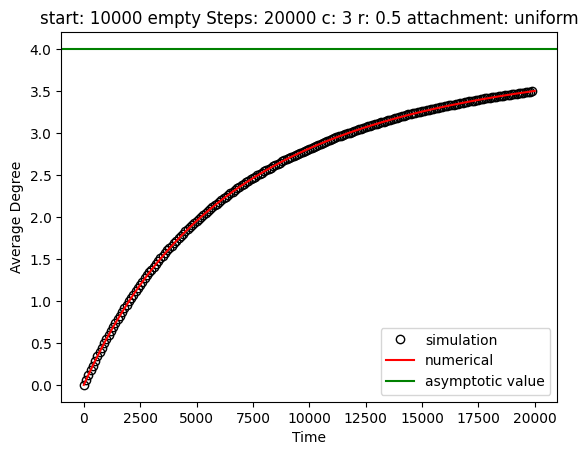

10000 False 25000 8 1.0 uniform
1.0 8 24999.0
50
1.0 8


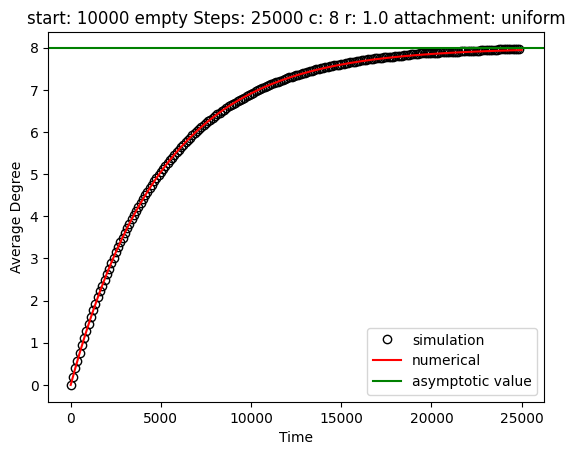

10000 False 5000 4 2.0 uniform
2.0 4 2499.5
50
2.0 4


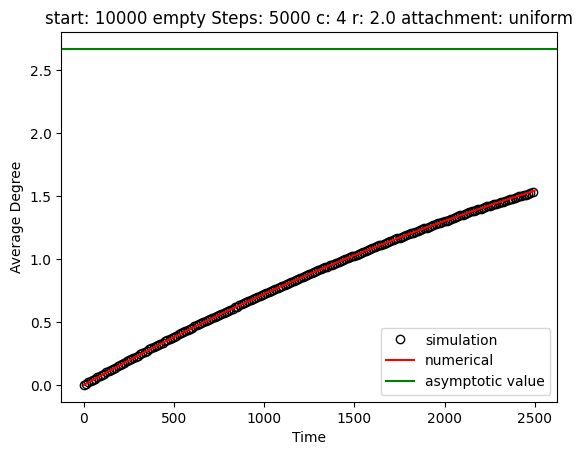

1000 False 5000 4 1.0 uniform
1.0 4 4999.0
50
1.0 4


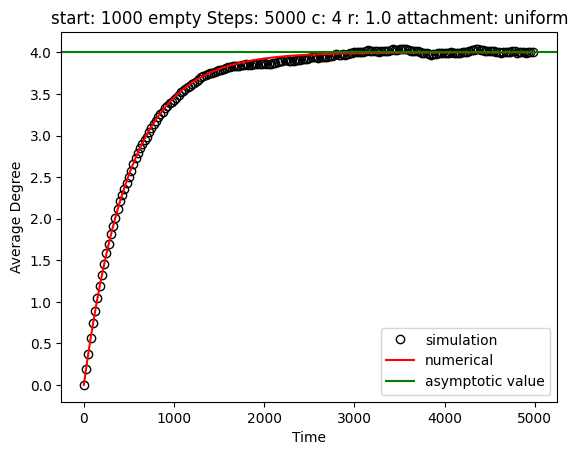

10 True 2000 10 0.5 preferential
0.5 10 1999.0
175
0.5 10


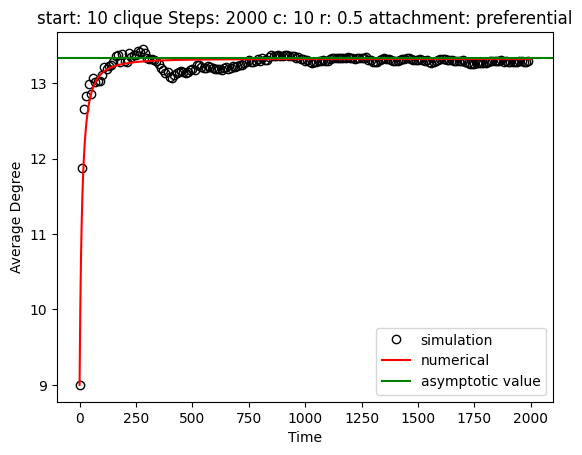

10 True 25000 8 0.5 preferential
0.5 8 24999.0
175
0.5 8


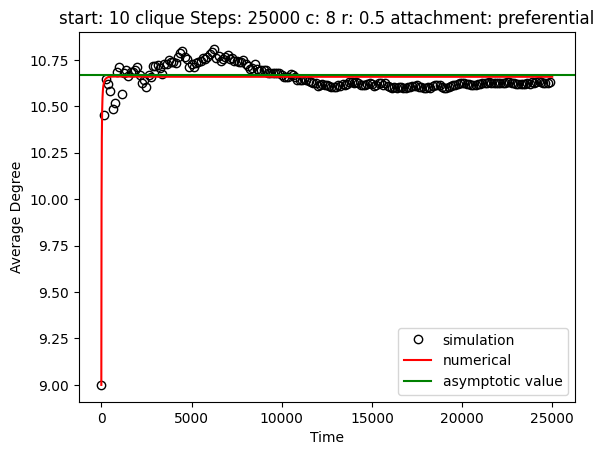

10 True 5000 10 0.5 preferential
0.5 10 4999.0
175
0.5 10


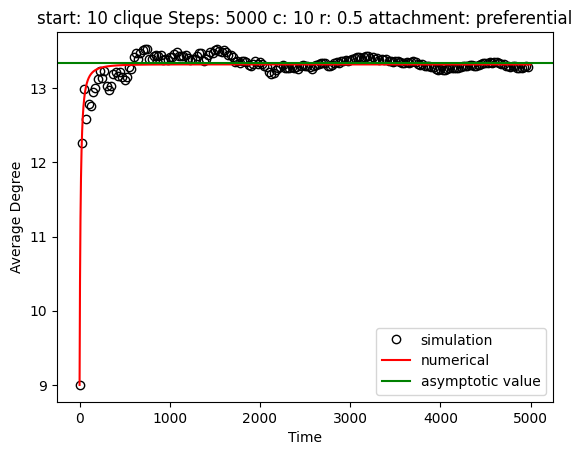

5 True 500 4 0.25 preferential
0.25 4 499.0
175
0.25 4


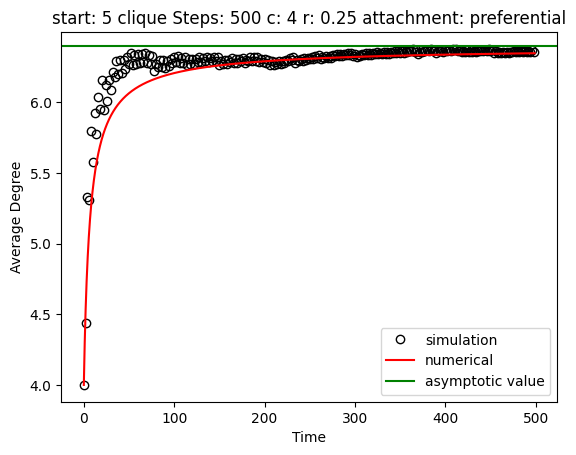

8 True 1000 5 0.5 preferential
0.5 5 999.0
175
0.5 5


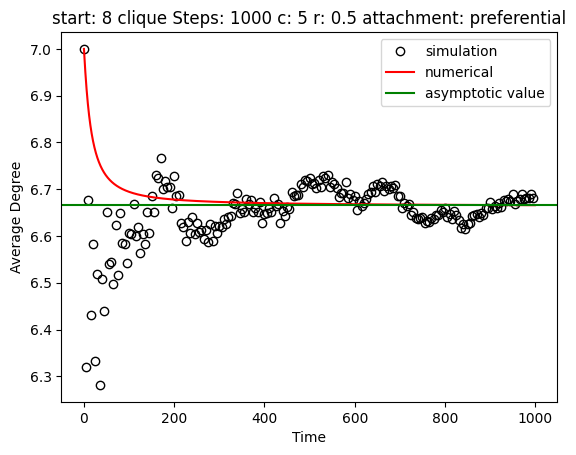

In [7]:
for prefix, file_list in get_simulation_files()[0].items():
    plot_avg_degree(prefix=prefix, file_list=file_list)

In [9]:
def calculate_mean(values: List[List[Dict[int, float]]]):

    num_files = len(values)
    num_steps = len(values[0])
    print(num_steps)

    def process(step_info: Dict[int, float], step: Dict[int, float]) -> None:
         for k, v in step_info.items():
            if not k in step:
                step[k] = float(v)/num_files
            else:
                 step[k] += float(v)/num_files

    series: List[Dict[int, float]] = []

    for i in range(0, num_steps):
            step = {}
            for file_data in values:
                process(file_data[i], step)
            for k, v in step.items():
                step[k] = float(v)
            series.append(step)
    
    series_as_dict = {}
    for idx, serie in enumerate(series):
        for key, value in serie.items():
            if not key in series_as_dict:
                series_as_dict[key] = np.zeros(num_steps)
            series_as_dict[key][idx] = value

    return series_as_dict

In [12]:
def plot_degree_distribution(prefix: str, file_list: List[str]) -> None:
    num_nodes, is_clique, num_steps, c, r, attachment = process_prefix(prefix)
    print(num_nodes, is_clique, num_steps, c, r, attachment)

    def build_dict(row):
        unique, counts = np.unique(row, return_counts=True)
        counts = counts / np.sum(counts)
        return dict(zip(unique, counts))

    values = []
    for file in file_list:
        with open(file) as f:
            next(f)
            lines = f.readlines()
            counts = []
            for line in lines:
                sizes = np.fromstring(line, dtype=int, sep=" ")
                counts.append(build_dict(sizes))
            values.append(counts)

    series = calculate_mean(values)

    min_step: float = 1

    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))

    x_values = np.arange(num_steps) * min_step

    print("starting simulation")

    times, Pks = solve_numerically(
        initial_nodes=num_nodes,
        r=r,
        c=c,
        is_clique=is_clique,
        preferential_attachment=(attachment == "preferential"),
        At=0.1,
        max_time=int(x_values[-1] * (0.75)),
    )

    print("simulation done")

    plt.ylim(0.00001, 1)

    skip_size = len(x_values) // 200

    plt.yscale("log")
    for k, pk_values in series.items():
        if k < 10:
            plt.plot(
                x_values[::skip_size],
                pk_values[::skip_size],
                label=str(k) + " - simulation",
                marker="o",
                mfc="none",
                linestyle="none",
            )

    for k in range(10):
        print("plotting k: ", k)
        plt.plot(
            times, [Pk[k] for Pk in Pks], label=str(k) + " - analytical"
        )

    plt.xlabel("Time")
    plt.ylabel("Degree Distribution")

    plt.legend()
    plt.title(
        "start: "
        + str(num_nodes)
        + (" clique" if is_clique else " empty")
        + " Steps: "
        + str(num_steps)
        + " c: "
        + str(c)
        + " r: "
        + str(r)
        + " attachment: "
        + attachment
    )
    plt.show()


10000 False 25000 8 1.0 uniform
25000
starting simulation
1.0 8 18749
50
simulation done
plotting k:  0
plotting k:  1
plotting k:  2
plotting k:  3
plotting k:  4
plotting k:  5
plotting k:  6
plotting k:  7
plotting k:  8
plotting k:  9


C:\Users\mique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


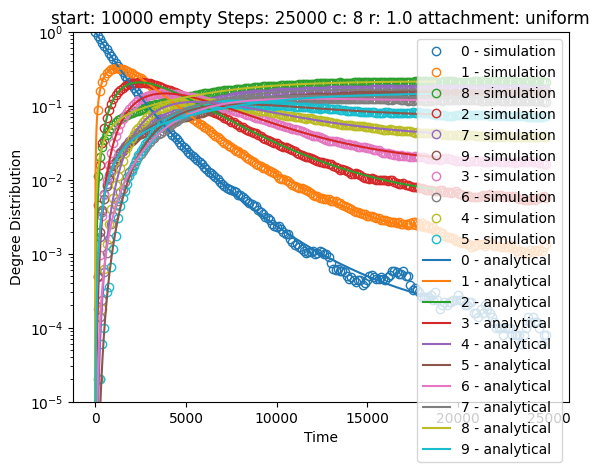

1000 False 5000 4 1.0 uniform
5000
starting simulation
1.0 4 3749
50
simulation done
plotting k:  0
plotting k:  1
plotting k:  2
plotting k:  3
plotting k:  4
plotting k:  5
plotting k:  6
plotting k:  7
plotting k:  8
plotting k:  9


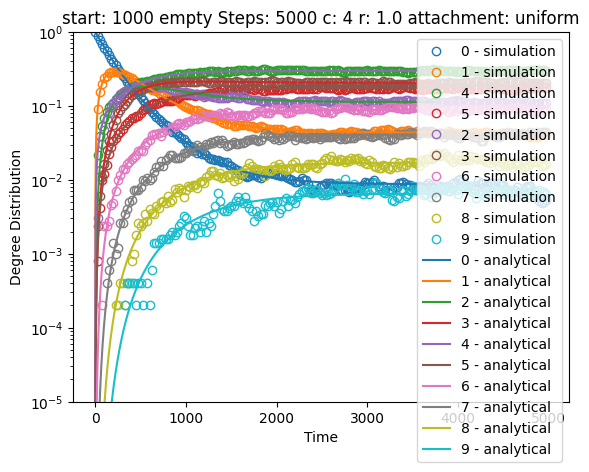

10 True 5000 4 0.5 preferential
5000
starting simulation
0.5 4 3749
175
simulation done
plotting k:  0
plotting k:  1
plotting k:  2
plotting k:  3
plotting k:  4
plotting k:  5
plotting k:  6
plotting k:  7
plotting k:  8
plotting k:  9


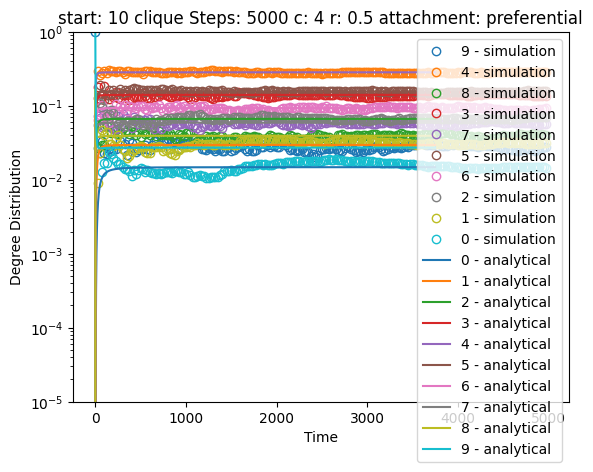

10 True 700 8 0.25 preferential
700
starting simulation
0.25 8 524
175
simulation done
plotting k:  0
plotting k:  1
plotting k:  2
plotting k:  3
plotting k:  4
plotting k:  5
plotting k:  6
plotting k:  7
plotting k:  8
plotting k:  9


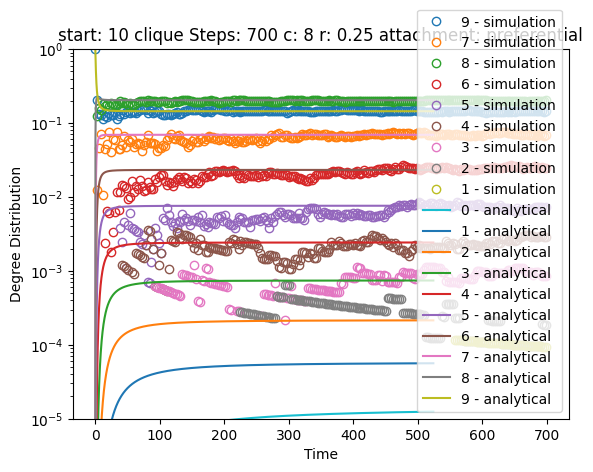

8 True 700 2 0.5 preferential
700
starting simulation
0.5 2 524
175
simulation done
plotting k:  0
plotting k:  1
plotting k:  2
plotting k:  3
plotting k:  4
plotting k:  5
plotting k:  6
plotting k:  7
plotting k:  8
plotting k:  9


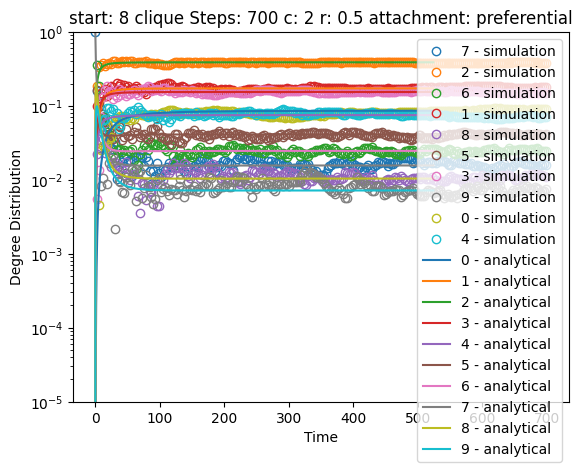

In [14]:
files = get_simulation_files()[1]
for prefix, file_list in files.items():
    plot_degree_distribution(prefix=prefix, file_list=file_list)


In [17]:
def plot_giant_component(prefix: str, file_list: List[str]) -> None:

    num_nodes, is_clique, num_steps, c, r, attachment = process_prefix(prefix)
    print(num_nodes, is_clique, num_steps, c, r, attachment)

    min_step: float = 1
    avg_size = np.zeros(num_steps)
    for file in file_list:
        with open(file) as f:
            next(f)
            lines = f.readlines()
            for step, line in enumerate(lines):
                [size, step_nodes] = np.fromstring(line, dtype=int, sep=" ")
                avg_size[step] += float(size) / float(step_nodes)
    avg_size = avg_size / len(file_list)

    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))


    x_values = np.arange(num_steps) * min_step
    skip_size: int = num_steps // 100
    plt.title(
        "start: "
        + str(num_nodes)
        + (" clique" if is_clique else " empty")
        + " Steps: "
        + str(num_steps)
        + " c: "
        + str(c)
        + " r: "
        + str(r)
        + " attachment: "
        + attachment
    )
    plt.scatter(x_values[::skip_size], avg_size[::skip_size])
    plt.xlabel("Time")
    plt.ylabel("Giant Component Size")
    plt.show()

# try small c values

# study asympotic "missing nodes" through p0

10000 False 25000 8 1.0 uniform


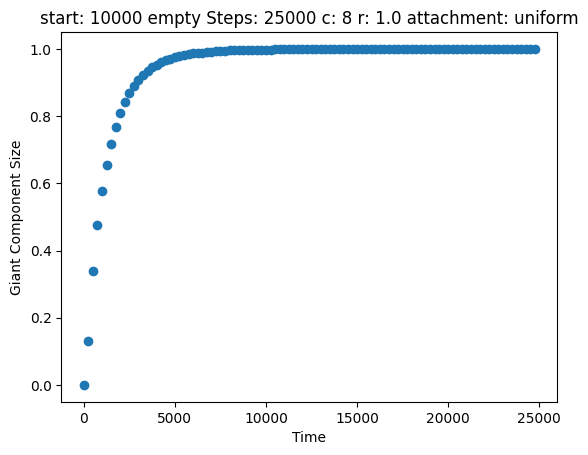

1000 False 5000 4 1.0 uniform


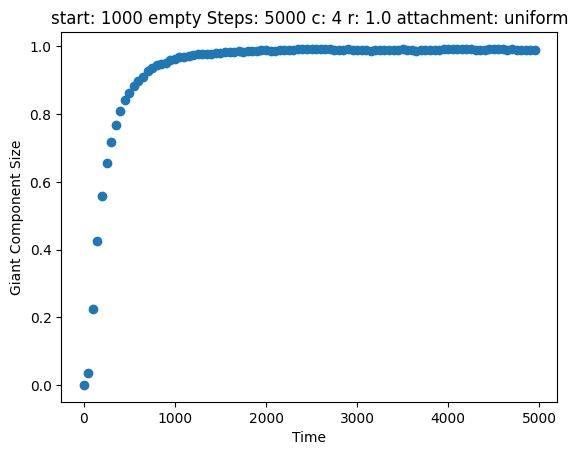

10 True 1500 4 0.5 preferential


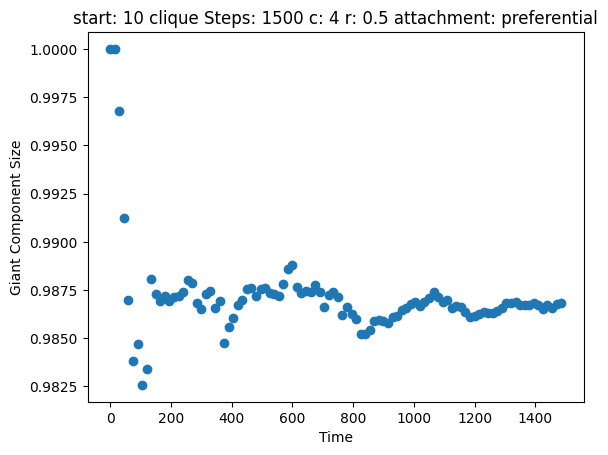

10 True 5000 4 0.5 preferential


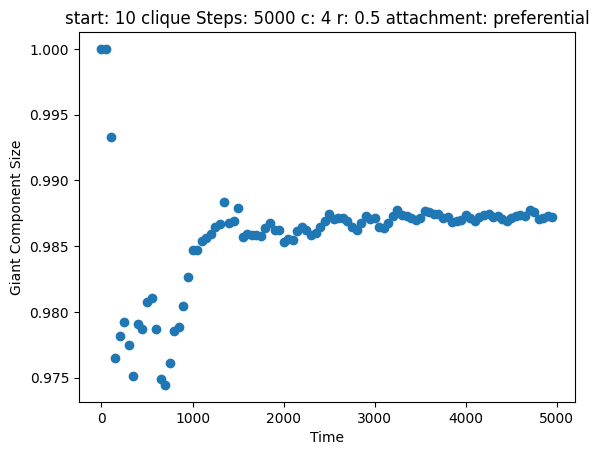

10 True 700 6 0.5 preferential


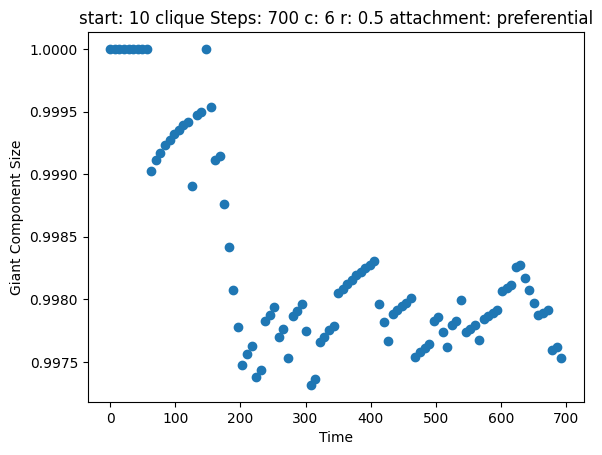

In [18]:
files = get_simulation_files()[2]
for prefix, file_list in files.items():
    plot_giant_component(prefix=prefix, file_list=file_list)


In [10]:
def remove_max_and_avg(nums):
    no_nulls = nums[~np.isnan(nums)]
    return (np.sum(no_nulls) - np.max(no_nulls)) / np.size(no_nulls)

In [11]:
def plot_avg_size_of_small_component(prefix: str, file_list: List[str]) -> None:
    num_nodes, is_clique, num_steps, c, r, attachment = process_prefix(prefix)
    print(num_nodes, is_clique, num_steps, c, r, attachment)

    min_step: float = 1
    avg_small_sizes = np.zeros(num_steps)
    for file in file_list:
        with open(file) as f:
            next(f)
            lines = f.readlines()
            for step, line in enumerate(lines):
                sizes = np.fromstring(line, dtype=int, sep=" ")
                val = (np.sum(sizes) - np.max(sizes)) / max((np.size(sizes) - 1), 1)
                avg_small_sizes[step] += val
    avg_small_sizes /= len(file_list)
    with open(file_list[0]) as f:
        min_step = float(f.readline().strip("\n"))

    x_values = np.arange(num_steps) * min_step / (float(num_nodes))
    skip_size: int = num_steps // 100
    plt.title(
        "start: "
        + str(num_nodes)
        + (" clique" if is_clique else " empty")
        + " Steps: "
        + str(num_steps)
        + " c: "
        + str(c)
        + " r: "
        + str(r)
        + " attachment: "
        + attachment
    )
    plt.errorbar(x_values[::skip_size], avg_small_sizes[::skip_size], fmt="o")
    plt.xlabel("Time")
    plt.ylabel("Average Size of Small Component")
    plt.show()

# average over existing small components

10000 False 25000 8 1.0 uniform


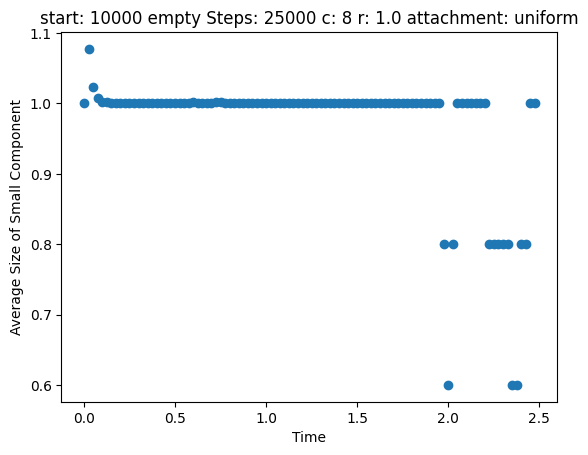

1000 False 5000 4 1.0 uniform


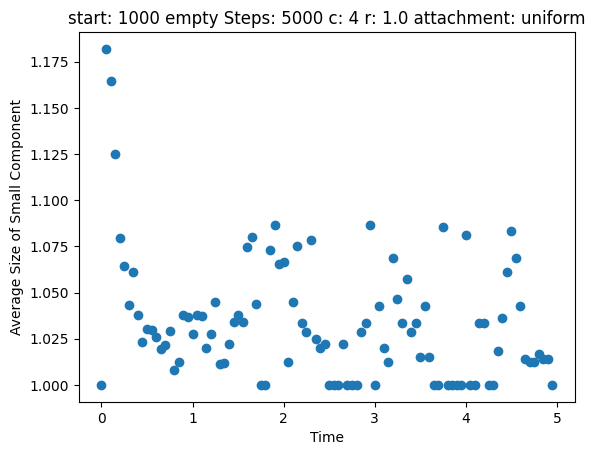

10 True 25000 8 0.5 preferential


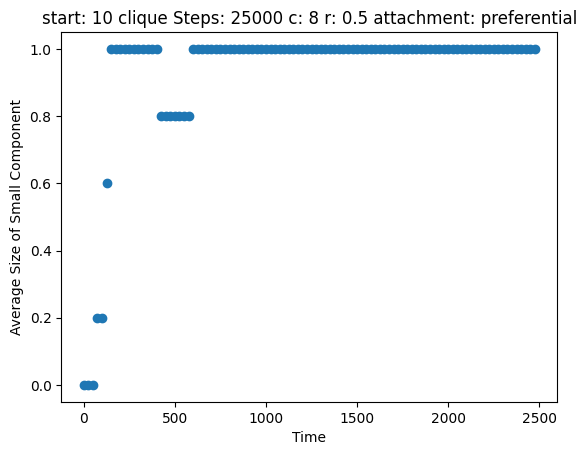

10 True 5000 4 0.5 preferential


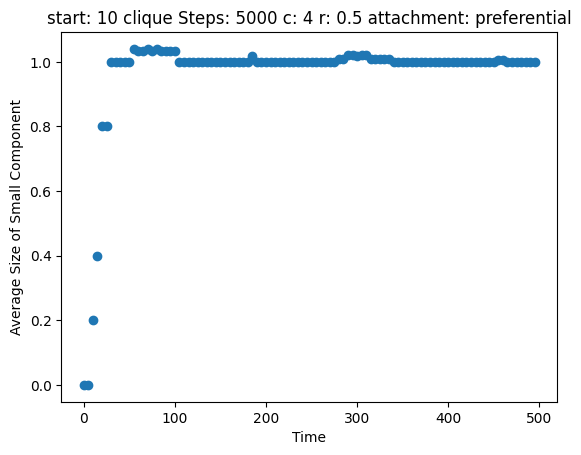

In [12]:
files = get_simulation_files()[3]
for prefix, file_list in files.items():
    plot_avg_size_of_small_component(prefix=prefix, file_list=file_list)
